# Analyse accuracy of Schroedinger-schemes

In [1]:
from IPython.display import display, Markdown, Latex 

%run sps_test_suite.py

In [2]:
def analyseError(
    scheme,
    config,
    generateIC,
    analyticalSolution,
    N=5,
    increaseSpatialResolution = 2, 
    increaseTemporalResolution = 1, 
    debug=False,
    waveScheme = None, 
    advection = False,
    potential = None,
):
    NX = config["resolution"]
    L = config["domainSize"]
    tEnd = config["tEnd"]
    dx = L / NX
    dt = config["dt"]
    error = np.zeros(N)

    resolutions = []
    average_timesteps = []

    for i in range(N):
        config["resolution"] = NX
        config["dt"]         = dt
        solver = scheme(config, generateIC)
        #solver.setExternalPotentialFunction(potential)
        if waveScheme is not None:
            waveSolver = waveScheme(config, generateIC)
            #waveSolver.setExternalPotentialFunction(potential)
        else:
            waveSolver = None 

        dx = solver.dx 
        nt = 0
        timesteps = [0]
        solver.run()
        if waveSolver is not None:
            waveSolver.run()

        if waveScheme is None:
            if advection:
                ana, _  = analyticalSolution(*solver.grid, solver.dx, solver.t)
            else:
                ana = np.abs(analyticalSolution(*solver.grid, solver.dx, solver.t)) ** 2
        else:
            ana = np.abs(waveSolver.getPsi())**2

        num = solver.getDensity()

        error[i] = np.mean(np.abs(num - ana))
        resolutions.append(dx)
        average_timesteps.append(np.mean(timesteps))


        if debug:
            print("dx ", dx, " dt ", np.mean(timesteps))
            print("error [i]: ", i, error[i])
            animation.drawFrame(solver, waveSolver = waveSolver)
            plt.show()

        NX *= increaseSpatialResolution
        NX = int(NX)
        dt /= increaseTemporalResolution
            
    return error, resolutions, average_timesteps


# Test: accuracy test 2D

Constructing upwind scheme scheme
Setting up fourier grid
Finished in 640 time steps
dx  0.125  dt  0.0
error [i]:  0 0.002880021143227527


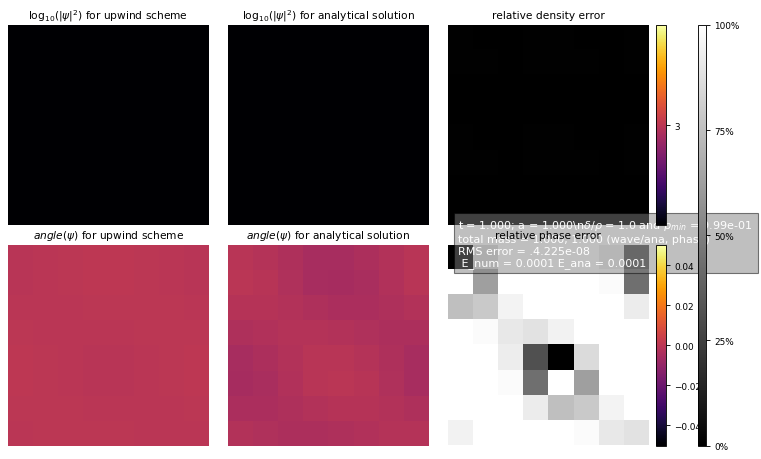

Constructing upwind scheme scheme
Setting up fourier grid
Finished in 1441 time steps
dx  0.08333333333333333  dt  0.0
error [i]:  1 0.0020456245566748054


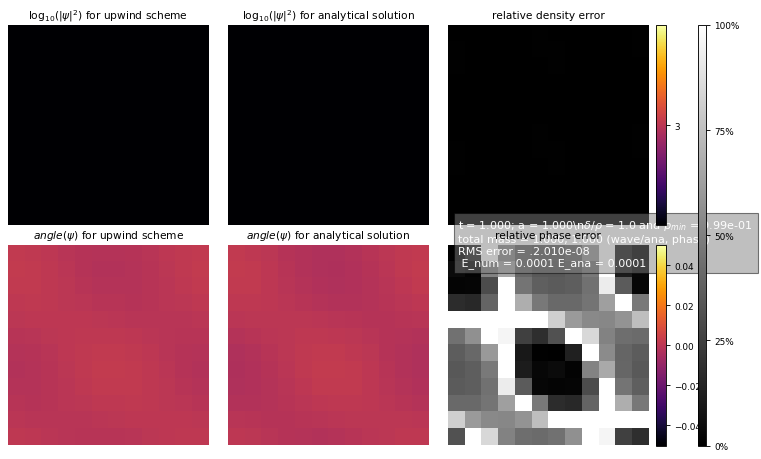

Constructing upwind scheme scheme
Setting up fourier grid
Finished in 3240 time steps
dx  0.05555555555555555  dt  0.0
error [i]:  2 0.0009712267397826671


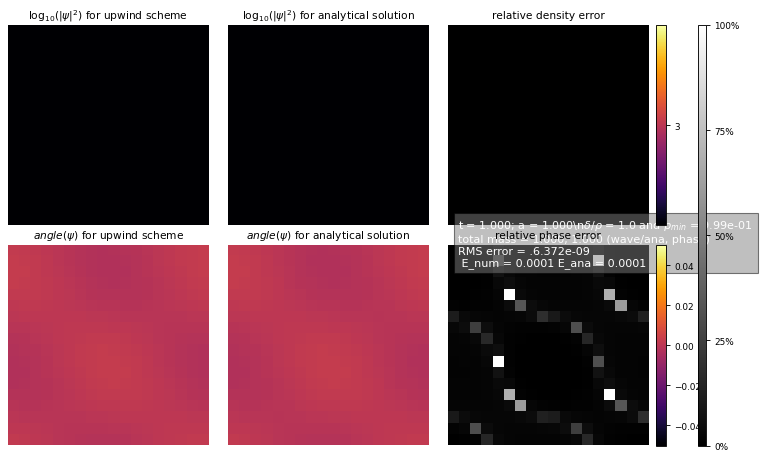

Constructing upwind scheme scheme
Setting up fourier grid
Finished in 7291 time steps
dx  0.037037037037037035  dt  0.0
error [i]:  3 0.0004353329566220885


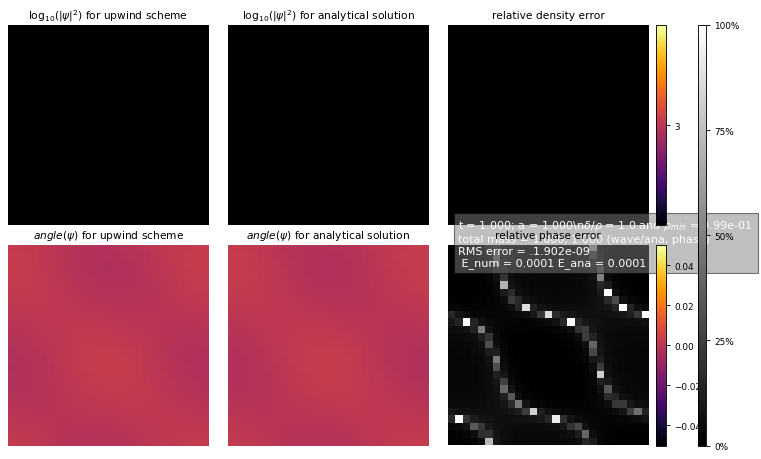

Constructing upwind scheme scheme
Setting up fourier grid


In [3]:
N = 6
#test_names_1d  = ['accuracy test']
#test_names  = ["harmonic oscillator coherent state"]
#test_names  = ['periodic gaussian wave packet']
#test_names  = ['perturbation wave 2D', 'perturbation wave 3D']
test_names = ['accuracy test 2D']#, 'accuracy test 3D']
schemes_for_accuracy_test = ["phase-upwind", "phase-ho-upwind_mc"]#, "phase-ho-upwind_leer", "phase-ho-upwind_albada"]
#schemes_for_accuracy_test = ["phase-ho-upwind_albada"]"wave-ftcs2", "wave-ftcs4", 
advection  = False
waveScheme = None#wave_schemes.SpectralScheme

increaseSpatialResolution  = 1.3
increaseTemporalResolution = 1 
suffix = ""
plotRuns = True 

for test_name in test_names:
    test, testConfig, potential = test_list[test_name]

    display(Markdown('#' + " Test: " + test_name))

    truncations_errors = {}

    for scheme_name in schemes_for_accuracy_test:
        scheme, schemeConfig = scheme_list[scheme_name]

        c = getBaseConfig()
        testConfig(c)
        schemeConfig(c)
        c["stencilOrder"] = 2
        c["C_parabolic"] = 0.1

        p, dx, dt = analyseError(
            scheme,
            c,
            test,
            test,
            N=N,
            increaseTemporalResolution = increaseTemporalResolution, 
            increaseSpatialResolution = increaseSpatialResolution,
            debug=plotRuns,
            waveScheme= waveScheme,
            advection = advection,
            potential = potential
        )

        truncations_errors[scheme_name] = {
            "errors": p,
            "dx": dx,
            "dt": dt
        }
        filename = "data/truncation_error_" + test_name.replace(" ", "_") + "_" + scheme_name.replace(" ", "_") + suffix + ".npz"
        print(filename)
        np.savez(filename, **(truncations_errors[scheme_name]))